<a href="https://colab.research.google.com/github/CEZERT/Google_localisation/blob/main/google_pos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -r '/content/drive/MyDrive/Colab Notebooks/requirement.txt'

On 2022-12-07, the count was maximum with 99 records.


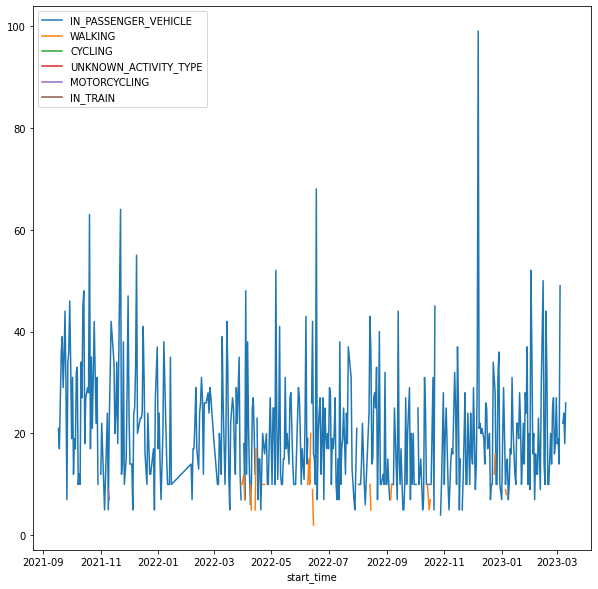

In [ ]:
import datetime as dt
from datetime import datetime
import json
import os
import contextily as cx
import folium
import geopandas as gp
import mapclassify
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as sg
from matplotlib import cm
from matplotlib.lines import Line2D

json_folder = "/content/drive/MyDrive/Colab Notebooks/Historique des positions"

def extract_activity(record):
    activity_type = record['activitySegment']['activityType']
    confidence = record['activitySegment']['confidence']
    start_time = dt.datetime.fromisoformat(record['activitySegment']['duration']['startTimestamp'].rstrip('Z'))
    end_time = dt.datetime.fromisoformat(record['activitySegment']['duration']['endTimestamp'].rstrip('Z'))
    distance = record['activitySegment']['distance'] if 'latitudeE7' in record['activitySegment'] else 0
    start_lat = record['activitySegment']['startLocation']['latitudeE7'] / 10 ** 7
    start_lon = record['activitySegment']['startLocation']['longitudeE7'] / 10 ** 7
    end_lat = record['activitySegment']['endLocation']['latitudeE7'] / 10 ** 7
    end_lon = record['activitySegment']['endLocation']['longitudeE7'] / 10 ** 7
    activities = record['activitySegment']['activities']
    return activity_type, confidence, start_time, end_time, distance, start_lat, start_lon, end_lat, end_lon


def extract_placevisite(record):
    location_name = record['placeVisit']['location']['name'] if 'name' in record['placeVisit']['location'] else ''
    start_time = dt.datetime.fromisoformat(record['placeVisit']['duration']['startTimestamp'].rstrip('Z'))
    end_time = dt.datetime.fromisoformat(record['placeVisit']['duration']['endTimestamp'].rstrip('Z'))
    start_lat = record['placeVisit']['location']['latitudeE7'] / 10 ** 7 if 'latitudeE7' in record['placeVisit']['location'] else 0
    start_lon = record['placeVisit']['location']['longitudeE7'] / 10 ** 7 if 'longitudeE7' in record['placeVisit']['location'] else 0
    address = record['placeVisit']['location']['address'] if 'address' in record['placeVisit']['location'] else ''
    return location_name, address, start_time, end_time, start_lat, start_lon


def extract_waypoints(record):
  waypoints = record['activitySegment']['waypointPath']['waypoints'] if 'waypointPath' in record['activitySegment'] else ''
  activity_type = record['activitySegment']['activityType']
  confidence = record['activitySegment']['confidence']
  start_time = dt.datetime.fromisoformat(record['activitySegment']['duration']['startTimestamp'].rstrip('Z'))
  end_time = dt.datetime.fromisoformat(record['activitySegment']['duration']['endTimestamp'].rstrip('Z'))
  distance = record['activitySegment']['distance'] if 'latitudeE7' in record['activitySegment'] else 0
  activities = record['activitySegment']['activities']
  for w in waypoints:
      w['activity_type'] = activity_type
      w['confidence'] = confidence
      w['start_time'] = start_time
      w['end_time'] = end_time
      w['distance'] = distance
  return waypoints


def parse_json_activities_start(folder):
  activities = []
  for root, dirs, files in os.walk(json_folder):
    for file in files:
        if file.endswith('.json') and file[0] == '2' and file[4] == '_':
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
            records = data['timelineObjects']
            for record in records:
                if 'activitySegment' in record:
                    activity = extract_activity(record)
                    activities.append(activity)
  df_activity = pd.DataFrame(activities, columns=['activity_type', 'confidence', 'start_time', 'end_time', 'distance','start_lat', 'start_lon', 'end_lat', 'end_lon'])
  df = df_activity.drop(['end_time','end_lat', 'end_lon'], axis = 1)
  points = [sg.Point(lon, lat) for lat, lon in zip(df['start_lat'], df['start_lon'])]
  df = gp.GeoDataFrame({'activity_type':df['activity_type'],'start_lat': df['start_lat'], 'start_lon': df['start_lon']}, geometry=points, crs=4326)
  df['activity_type'] = df['activity_type'].astype(str)
  df['start_time'] = df_activity['start_time'].astype(str)
  df['end_time'] = df_activity['end_time'].astype(str)
  return df

def parse_json_activities_end(folder):
  activities = []
  for root, dirs, files in os.walk(json_folder):
    for file in files:
        if file.endswith('.json') and file[0] == '2' and file[4] == '_':
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
            records = data['timelineObjects']
            for record in records:
                if 'activitySegment' in record:
                    activity = extract_activity(record)
                    activities.append(activity)
  df_activity = pd.DataFrame(activities, columns=['activity_type', 'confidence', 'start_time', 'end_time', 'distance','start_lat', 'start_lon', 'end_lat', 'end_lon'])
  df = df_activity.drop(['start_time','start_lat', 'start_lon'], axis = 1)
  points = [sg.Point(lon, lat) for lat, lon in zip(df['end_lat'], df['end_lon'])]
  df = gp.GeoDataFrame({'start_lat': df['end_lat'], 'start_lon': df['end_lon']}, geometry=points, crs=4326)
  df['activity_type'] = df_activity['activity_type'].astype(str)
  df['start_time'] = df_activity['start_time'].astype(str)
  df['end_time'] = df_activity['end_time'].astype(str)
  return df


def wps(folder):
    latitudes = []
    longitudes = []
    wpp = []
    activities_type = []
    confide = []
    start_t = []
    end_tim = []
    distanc = []
    activit = []
    for root, dirs, files in os.walk(json_folder):
        for file in files:
            if file.endswith('.json') and file[0] == '2' and file[4] == '_':
                with open(os.path.join(root, file), 'r') as f:
                    data = json.load(f)
                records = data['timelineObjects']
                for record in records:
                    if 'activitySegment' in record:
                        waypoints = extract_waypoints(record)
                        wpp.append(waypoints)
    for i in wpp:
        try:
            for wp in i:
                if wp['latE7'] != 0 and wp['lngE7'] != 0:
                    activities_type.append(wp['activity_type'])
                    confide.append(wp['confidence'])
                    start_t.append(wp['start_time'])
                    end_tim.append(wp['end_time'])
                    distanc.append(wp['distance'])
                    latitudes.append(wp['latE7'] / 10**7)  # Convert latitude from E7 to degrees
                    longitudes.append(wp['lngE7'] / 10**7)  # Convert longitude from E7 to degrees
        except TypeError:
            pass

  # Create a pandas dataframe from latitude and longitude lists
    dff = pd.DataFrame({'activity_type': activities_type,'confidence':confide,'start_time':start_t,'end_time':end_tim,'distance':distanc, 'Latitude': latitudes, 'Longitude': longitudes})
    points = [sg.Point(lon, lat) for lat, lon in zip(dff['Latitude'], dff['Longitude'])]
    df = gp.GeoDataFrame({ 'activity_type': activities_type, 'confidence':confide, 'start_time':start_t, 'end_time':end_tim, 'distance':distanc, 'Latitude': latitudes, 'Longitude': longitudes}, geometry=points, crs=4326)
    df['start_time'] = df['start_time'].astype(str)
    df['end_time'] = df['end_time'].astype(str)
    return df


def parse_json_visites(folder):
  place_visites = []
  points = []
  for root, dirs, files in os.walk(json_folder):
    for file in files:
        if file.endswith('.json') and file[0] == '2' and file[4] == '_':
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
            records = data['timelineObjects']
            for record in records:
                if 'placeVisit' in record:
                    visites = extract_placevisite(record)
                    place_visites.append(visites)
  dff = pd.DataFrame(place_visites, columns=['location_name', 'address', 'start_time', 'end_time', 'start_lat', 'start_lon'])
  points = [sg.Point(lon, lat) for lat, lon in zip(dff['start_lat'], dff['start_lon'])]
  df = gp.GeoDataFrame(place_visites,columns=['location_name', 'address', 'start_time', 'end_time', 'start_lat', 'start_lon'],geometry=points, crs=4326)
  df['start_time'] = df['start_time'].astype(str)
  df['end_time'] = df['end_time'].astype(str)
  return df


world = gp.read_file('/content/drive/MyDrive/Colab Notebooks/Historique des positions/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp', allow_override=True).to_crs('EPSG:4326')
# gdf_visites = parse_json_visites(json_folder)
# gdf_visites.set_crs(epsg=4326, allow_override=True)
gdf_wps = wps(json_folder)
gdf_wps.set_crs(epsg=4326, allow_override=True)
gdf_start = parse_json_activities_start(json_folder)
gdf_start.set_crs(epsg=4326, allow_override=True)
gdf_end = parse_json_activities_end(json_folder)
gdf_end.set_crs(epsg=4326, allow_override=True)
gdff = pd.concat([gdf_wps, gdf_start, gdf_end], ignore_index=True)
gdf = gdff.reset_index(drop=True)

def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    # labels = [df.start_time.quantile(step).strftime("%Y-%m-%d") for step in vals]
    labels = [df.start_time.quantile(step).strftime("%Y-%m-%d").astype(str) for step in vals]
    labels = [df.start_time.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower right")


def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()


def calculate_pal(df, cmap):
    min_ts = seconds(df.start_time.min())
    max_ts = seconds(df.start_time.max())
    return df.start_time.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()


def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(20, 12), alpha = 0)
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('turbo')
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', color=pal, markersize=8)
    cx.add_basemap(ax, crs=df.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=12, alpha = 0.8)
    compute_legend(box_only, ax, cmap, 5)


def dt_to_date(dt_str):
    dt_format = '%Y-%m-%d %H:%M:%S.%f'
    dt = datetime.strptime(dt_str, dt_format) # convertir la chaîne en datetime
    return dt.date()


def aggregate_by(df, function):
    tuples = []
    for activity in df.activity_type.drop_duplicates():
        group = df[df.activity_type == activity].groupby(df.start_time.apply(function)).activity_type.agg('count')
        tuples.append((activity, group))
    return pd.DataFrame(dict(tuples))
import pandas as pd


def aggregate_by_max(df, function):
    group = df.groupby(df.start_time.apply(function)).activity_type.agg('count')
    max_date = group.idxmax()
    max_count = group.max()
    return f"On {max_date}, the count was maximum with {max_count} records."


df_by_day = aggregate_by(gdf, dt_to_date)
df_by_day.plot(figsize=[10,10])
print(aggregate_by_max(gdf, dt_to_date))
#gdf.altitude.plot.hist(figsize=[10,10], bins=200, log=True) #Pour faire histogramme
# draw_map(gdf_wps, sg.box(1, 43.4, 1.6, 44))
#draw_map(gdf_visites, sg.box(0, 43, 2, 45))
#gdf.explore()
#print(read_json(json_folder))
